In [1]:
import numpy as np
# import cv2
import tifffile as tiff
from shapely.geometry import Polygon, mapping, shape, box
from skimage import io
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
# import json
from rasterio import features
import scanpy as sc
import pandas as pd
import geopandas as gpd

from matplotlib import colors

import pickle
import scipy

import seaborn as sns

from SGanalysis.SGobject import SGobject 

import matplotlib
%matplotlib inline
# matplotlib.use('Qt5Agg')
# %matplotlib qt

from sklearn.cluster import AgglomerativeClustering as AggCluster

import sys
import os

%load_ext autoreload
%autoreload 2

tools_path  = '/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/analysis/tools/tools.py'
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
import tools

In [2]:
# filepath  = '/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/Shared_Grant/SpatialBarcodes/ImagingData/2024-02-27_spatialbarcodes_SG_expression/projects/2024-02-27_spatialbarcodes_expression/'
filepath = '/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/'

# roi_2
roi_name = 'roi_1'


# /roi_2

In [3]:
# locations = pd.read_csv(f'{filepath}{roi_name}/exports/cell_attributes_cell_10px_20240605.csv',index_col=0)
# matrix = pd.read_csv(f'{filepath}{roi_name}/exports/cell_by_gene_matrix_20240606_10px_cell.csv',index_col=0)

# matrix.set_index(matrix.index.astype(str),inplace=True)
# locations.set_index(matrix.index.astype(str),inplace=True)

# /Volumes/GRK_001/spatialbarcodes/2024-05-21_mouseexp_expression/projects/roi2/exports/
with open(f'{filepath}{roi_name}/exports/sg_object_20240604_dilate10.pkl', 'rb') as f:
    sg_obj = pickle.load(f)


In [5]:
# set object id (as string) as index

matrix = sg_obj.get_cell_gene_table_df()
matrix['object_id'] = [str(int(x)) for x in matrix['object_id']]
matrix.set_index('object_id',inplace=True)

sg_obj.gdf['object_id'] = [str(int(x)) for x in sg_obj.gdf['object_id']]
sg_obj.gdf.set_index('object_id',inplace=True)

No filtering available or applied.


In [6]:
sg_obj.gdf['nucleus_centroid'] = sg_obj.gdf['nucleus'].centroid.values
sg_obj.gdf['center_x'] = sg_obj.gdf['nucleus'].centroid.x.values
sg_obj.gdf['center_y'] = sg_obj.gdf['nucleus'].centroid.y.values
sg_obj.gdf['area'] = sg_obj.gdf['nucleus_dilated'].area.values

In [7]:
barcode_cols = ['bc_{:03d}'.format(i) for i in range(1,97)]

In [8]:
cutoff = 4

cell_barcodes = {}
# matrix.set_index('object_id',   inplace=True)
# df.set_index('object_id')

df = matrix

# df.sort_index(inplace=True)

df['cell_id'] = df.index

for cell_id in df['cell_id']:
    this_cell = df[df['cell_id']==cell_id]
    cell_barcodes[cell_id] = []

    for bc in barcode_cols:
        if this_cell[bc].values[0] > cutoff:
            cell_barcodes[cell_id].append(bc)

df['called_barcodes'] = cell_barcodes.values()
df['n_called_barcodes'] = [len(bc_set) for bc_set in cell_barcodes.values()]
df['barcode_names'] = ['-'.join(sorted(bc_set)) for bc_set in cell_barcodes.values()]

df = pd.merge(df,sg_obj.gdf,how='left',left_index=True,right_index=True)


In [9]:
gene_cols = [col for col in df.columns if 'bc_' not in col and col not in ['cell_id','called_barcodes','n_called_barcodes','barcode_names','area','center_x','center_y','nucleus','nucleus_centroid','nucleus_dilated']]    

In [10]:
adata_genes = sc.AnnData(df[gene_cols])

cols= ['cell_id','n_called_barcodes','barcode_names','called_barcodes','area','center_x','center_y']
# for col in :
#     adata_genes.obs[col] = df[col]

adata_genes.obs = df[cols]

In [11]:
min_area = 2000

adata_genes = adata_genes[adata_genes.obs['area']>min_area]

In [12]:
# filter cells and genes by number of occurences 
sc.pp.filter_cells(adata_genes, min_genes=15) # keep only cells that have at least 10 genes
sc.pp.filter_genes(adata_genes, min_cells=500) # keep only genes that are expressed in at least 500 cells

/Users/grantkinsler/opt/miniconda3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


(-143.8492144926497, 39974.20708684045, 1994.5630341310743, 62373.14330667359)

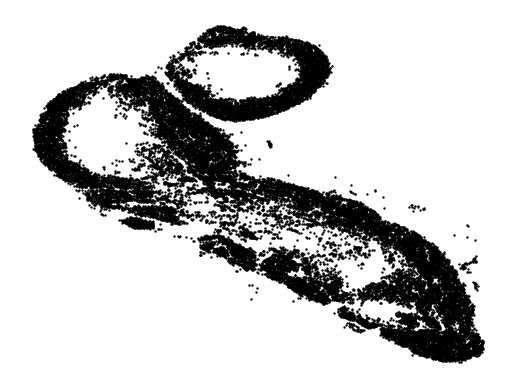

In [13]:
# bc_colors = sns.color_palette(sns.color_palette("tab20")+sns.color_palette("tab20b")+sns.color_palette("tab20c"),n_colors=len(clusters_to_show))
# bc_color_dict = {bc:bc_colors[i] for i,bc in enumerate(clusters_to_show)}

# bc_color_list = [colors.to_rgba(bc_color_dict[bc],alpha=1.0) if bc in bc_color_dict.keys() else colors.to_rgba('gray',alpha=0.02)  for bc in adata_genes.obs['bc_cluster'] ]

plt.scatter(adata_genes.obs['center_x'],adata_genes.obs['center_y'],marker='o',
            c='k',
            s=0.5)


plt.axis('off')

plt.
# plt.scatter('origin')
# plt.savefig(f'plots/{roi_name}_bc_clusters.pdf',bbox_inches='tight')